<a href="https://colab.research.google.com/github/tsemuchen/ece539_project/blob/main/mobNetV2_wideResNet101_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Define the transformation pipeline
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# No transform in ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# calculate the sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size

# Split
db_train, db_test = random_split(dataset, [train_size, test_size])

# Wrap with transforms
db_train = SubsetWithTransform(db_train, transform_train)
db_test = SubsetWithTransform(db_test, transform_test)

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

In [4]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [5]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [6]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, epochs=2, lr=0.001):

    # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Unique class labels from the dataset
    labels_list = list(range(len(dataset.classes)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_normalized = cm / cm.sum(axis=0, keepdims=True)  # Normalize by column (actual label)

    # Confusion matrix heatmap (x = Actual, y = Predicted)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_normalized.T, annot=cm.T, fmt='d', cmap="Blues",
        xticklabels=dataset.classes, yticklabels=dataset.classes,
        cbar_kws={"label": "Percentage of Actual Label"}
    )
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels_list, average=None)
    recall = recall_score(y_true, y_pred, labels=labels_list, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels_list, average=None)

    print(f"\nAccuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        class_name = dataset.classes[i]
        print(f"Class {i} ({class_name}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nMacro-Averaged Metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1 Score:  {macro_f1:.4f}")

In [21]:
# train-fine-tune-pipeline
def pipeline(model, name):
  global db_train, db_test, loader_train, loader_test

  # Define the model for 9-class classification
  if hasattr(model, 'mobilenet_v2'): #
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 9)
  elif hasattr(model, 'fc'):  # For DenseNet and other models
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 9)


  # Move entire model to device
  model = model.to(device)

  # Freeze feature extractor for ResNet and Wide ResNet
  if hasattr(model, 'fc'): # check for ResNet/WideResNet
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
  else: # assuming models with features attr here.
    for param in model.features.parameters():
        param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  train(model, loader_train, loader_test, epochs=8, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, epochs=10, lr=0.001)

  return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 119/119 [51:31<00:00, 25.98s/it]

Finished epoch 0 of 8: Train Loss = 0.980  Val Loss = 2.193   Train Acc = 0.664   Val Acc = 0.177



100%|██████████| 119/119 [00:42<00:00,  2.77it/s]

Finished epoch 1 of 8: Train Loss = 0.649  Val Loss = 0.618   Train Acc = 0.770   Val Acc = 0.774



100%|██████████| 119/119 [00:35<00:00,  3.32it/s]

Finished epoch 2 of 8: Train Loss = 0.524  Val Loss = 0.611   Train Acc = 0.813   Val Acc = 0.782



100%|██████████| 119/119 [00:36<00:00,  3.29it/s]

Finished epoch 3 of 8: Train Loss = 0.477  Val Loss = 0.612   Train Acc = 0.829   Val Acc = 0.782



100%|██████████| 119/119 [00:35<00:00,  3.34it/s]

Finished epoch 4 of 8: Train Loss = 0.467  Val Loss = 0.546   Train Acc = 0.836   Val Acc = 0.809



100%|██████████| 119/119 [00:36<00:00,  3.29it/s]

Finished epoch 5 of 8: Train Loss = 0.407  Val Loss = 0.642   Train Acc = 0.856   Val Acc = 0.791



100%|██████████| 119/119 [00:35<00:00,  3.31it/s]

Finished epoch 6 of 8: Train Loss = 0.380  Val Loss = 0.559   Train Acc = 0.866   Val Acc = 0.814



100%|██████████| 119/119 [00:35<00:00,  3.31it/s]

Finished epoch 7 of 8: Train Loss = 0.360  Val Loss = 0.543   Train Acc = 0.871   Val Acc = 0.812



100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


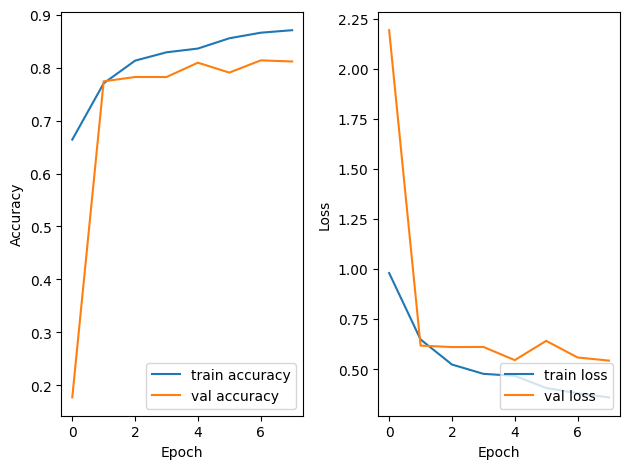

Test accuracy: 79.88%
Test loss: 0.579


100%|██████████| 119/119 [00:44<00:00,  2.68it/s]

Finished epoch 0 of 10: Train Loss = 0.411  Val Loss = 0.579   Train Acc = 0.856   Val Acc = 0.799



100%|██████████| 119/119 [00:44<00:00,  2.68it/s]

Finished epoch 1 of 10: Train Loss = 0.170  Val Loss = 0.498   Train Acc = 0.940   Val Acc = 0.844



100%|██████████| 119/119 [00:44<00:00,  2.67it/s]

Finished epoch 2 of 10: Train Loss = 0.055  Val Loss = 0.302   Train Acc = 0.986   Val Acc = 0.895



100%|██████████| 119/119 [00:44<00:00,  2.65it/s]

Finished epoch 3 of 10: Train Loss = 0.029  Val Loss = 0.278   Train Acc = 0.994   Val Acc = 0.911



100%|██████████| 119/119 [00:44<00:00,  2.66it/s]

Finished epoch 4 of 10: Train Loss = 0.022  Val Loss = 0.291   Train Acc = 0.996   Val Acc = 0.910



100%|██████████| 119/119 [00:44<00:00,  2.66it/s]

Finished epoch 5 of 10: Train Loss = 0.017  Val Loss = 0.290   Train Acc = 0.998   Val Acc = 0.923



100%|██████████| 119/119 [00:44<00:00,  2.66it/s]

Finished epoch 6 of 10: Train Loss = 0.011  Val Loss = 0.272   Train Acc = 0.999   Val Acc = 0.920



100%|██████████| 119/119 [00:43<00:00,  2.71it/s]

Finished epoch 7 of 10: Train Loss = 0.008  Val Loss = 0.263   Train Acc = 0.999   Val Acc = 0.910



100%|██████████| 119/119 [00:43<00:00,  2.72it/s]

Finished epoch 8 of 10: Train Loss = 0.008  Val Loss = 0.266   Train Acc = 0.999   Val Acc = 0.920



100%|██████████| 119/119 [00:43<00:00,  2.71it/s]

Finished epoch 9 of 10: Train Loss = 0.007  Val Loss = 0.278   Train Acc = 0.999   Val Acc = 0.912



100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


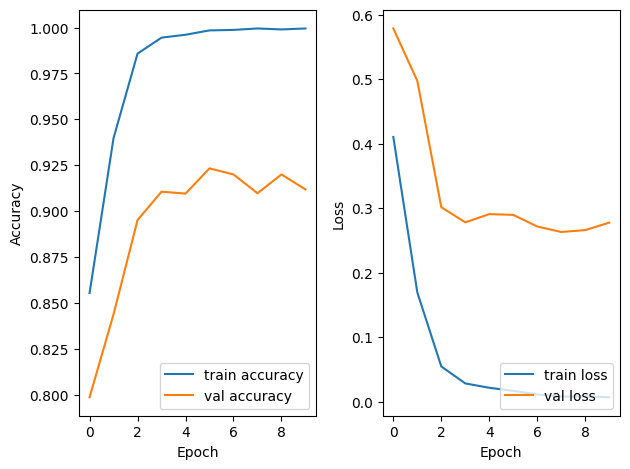

Test accuracy: 91.59%
Test loss: 0.269


In [14]:
# mobilenet_v2
mnet = pipeline(models.mobilenet_v2(pretrained=True), name='mobilenet_v2')

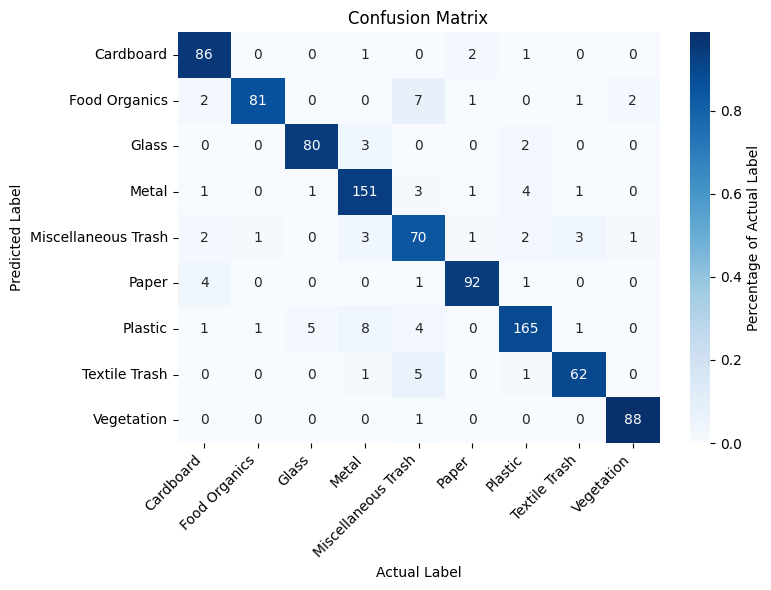


Accuracy: 0.9162
Class 0 (Cardboard): Precision: 0.9556, Recall: 0.8958, F1 Score: 0.9247
Class 1 (Food Organics): Precision: 0.8617, Recall: 0.9759, F1 Score: 0.9153
Class 2 (Glass): Precision: 0.9412, Recall: 0.9302, F1 Score: 0.9357
Class 3 (Metal): Precision: 0.9321, Recall: 0.9042, F1 Score: 0.9179
Class 4 (Miscellaneous Trash): Precision: 0.8434, Recall: 0.7692, F1 Score: 0.8046
Class 5 (Paper): Precision: 0.9388, Recall: 0.9485, F1 Score: 0.9436
Class 6 (Plastic): Precision: 0.8919, Recall: 0.9375, F1 Score: 0.9141
Class 7 (Textile Trash): Precision: 0.8986, Recall: 0.9118, F1 Score: 0.9051
Class 8 (Vegetation): Precision: 0.9888, Recall: 0.9670, F1 Score: 0.9778

Macro-Averaged Metrics:
Precision: 0.9169
Recall:    0.9156
F1 Score:  0.9154


In [15]:
# evaluate mobilenet_v2
evaluate_metrics(mnet, loader_test)

100%|██████████| 119/119 [01:19<00:00,  1.50it/s]

Finished epoch 0 of 8: Train Loss = 1.276  Val Loss = 2.209   Train Acc = 0.562   Val Acc = 0.110



100%|██████████| 119/119 [01:09<00:00,  1.72it/s]

Finished epoch 1 of 8: Train Loss = 0.802  Val Loss = 0.879   Train Acc = 0.725   Val Acc = 0.681



100%|██████████| 119/119 [01:07<00:00,  1.75it/s]

Finished epoch 2 of 8: Train Loss = 0.724  Val Loss = 0.808   Train Acc = 0.747   Val Acc = 0.732



100%|██████████| 119/119 [01:08<00:00,  1.74it/s]

Finished epoch 3 of 8: Train Loss = 0.617  Val Loss = 0.698   Train Acc = 0.779   Val Acc = 0.762



100%|██████████| 119/119 [01:07<00:00,  1.76it/s]

Finished epoch 4 of 8: Train Loss = 0.617  Val Loss = 0.646   Train Acc = 0.782   Val Acc = 0.779



100%|██████████| 119/119 [01:08<00:00,  1.75it/s]

Finished epoch 5 of 8: Train Loss = 0.612  Val Loss = 0.706   Train Acc = 0.785   Val Acc = 0.764



100%|██████████| 119/119 [01:07<00:00,  1.75it/s]

Finished epoch 6 of 8: Train Loss = 0.558  Val Loss = 0.679   Train Acc = 0.804   Val Acc = 0.776



100%|██████████| 119/119 [01:08<00:00,  1.75it/s]

Finished epoch 7 of 8: Train Loss = 0.501  Val Loss = 0.680   Train Acc = 0.828   Val Acc = 0.761



100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


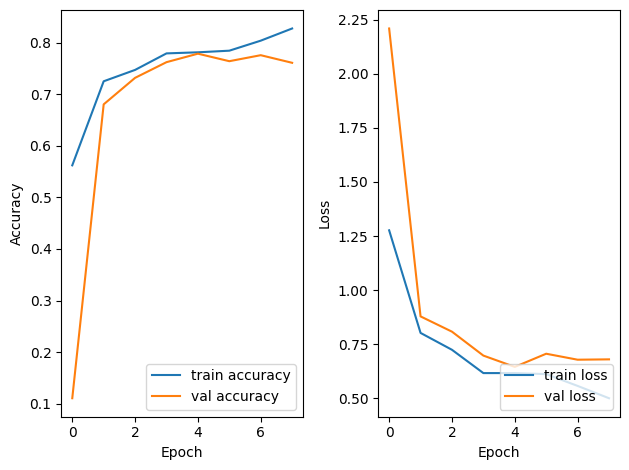

Test accuracy: 77.70%
Test loss: 0.672


100%|██████████| 119/119 [02:37<00:00,  1.33s/it]

Finished epoch 0 of 10: Train Loss = 0.444  Val Loss = 0.672   Train Acc = 0.852   Val Acc = 0.777



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 1 of 10: Train Loss = 0.081  Val Loss = 0.446   Train Acc = 0.975   Val Acc = 0.862



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 2 of 10: Train Loss = 0.031  Val Loss = 0.293   Train Acc = 0.992   Val Acc = 0.909



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 3 of 10: Train Loss = 0.016  Val Loss = 0.266   Train Acc = 0.998   Val Acc = 0.924



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 4 of 10: Train Loss = 0.009  Val Loss = 0.237   Train Acc = 0.999   Val Acc = 0.928



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 5 of 10: Train Loss = 0.005  Val Loss = 0.246   Train Acc = 0.999   Val Acc = 0.930



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 6 of 10: Train Loss = 0.003  Val Loss = 0.244   Train Acc = 1.000   Val Acc = 0.928



100%|██████████| 119/119 [02:37<00:00,  1.33s/it]

Finished epoch 7 of 10: Train Loss = 0.004  Val Loss = 0.234   Train Acc = 1.000   Val Acc = 0.931



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 8 of 10: Train Loss = 0.003  Val Loss = 0.234   Train Acc = 1.000   Val Acc = 0.931



100%|██████████| 119/119 [02:37<00:00,  1.32s/it]

Finished epoch 9 of 10: Train Loss = 0.003  Val Loss = 0.232   Train Acc = 1.000   Val Acc = 0.933



100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


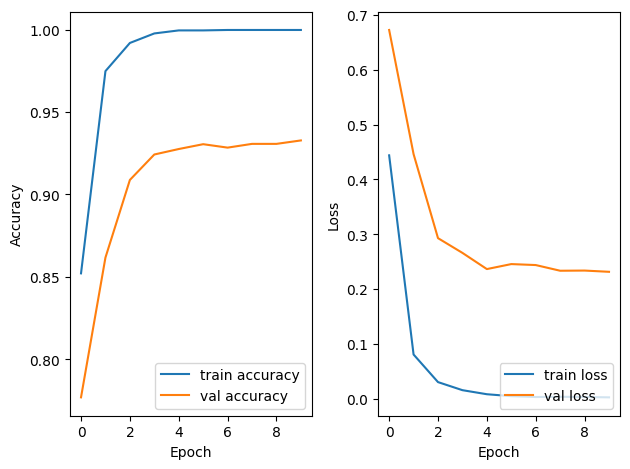

Test accuracy: 92.86%
Test loss: 0.242


In [22]:
wnet = pipeline(models.wide_resnet101_2(pretrained=True), name='fc')

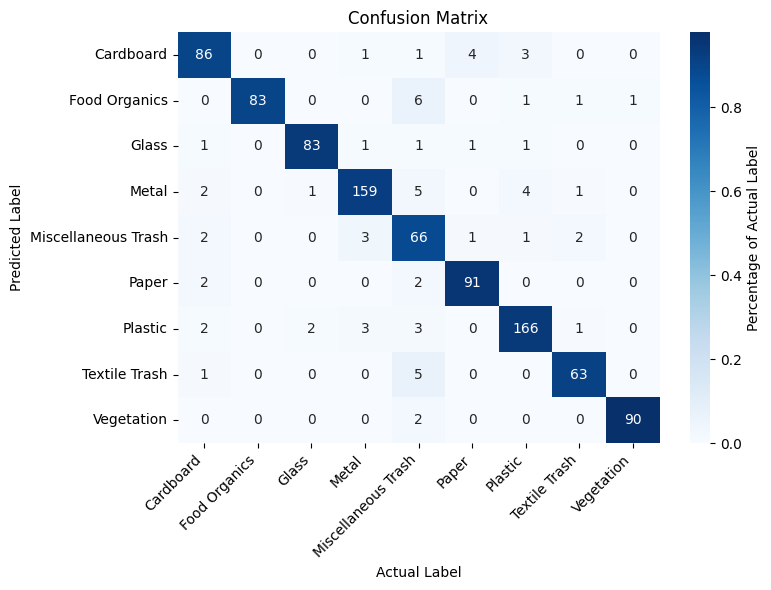


Accuracy: 0.9288
Class 0 (Cardboard): Precision: 0.9053, Recall: 0.8958, F1 Score: 0.9005
Class 1 (Food Organics): Precision: 0.9022, Recall: 1.0000, F1 Score: 0.9486
Class 2 (Glass): Precision: 0.9432, Recall: 0.9651, F1 Score: 0.9540
Class 3 (Metal): Precision: 0.9244, Recall: 0.9521, F1 Score: 0.9381
Class 4 (Miscellaneous Trash): Precision: 0.8800, Recall: 0.7253, F1 Score: 0.7952
Class 5 (Paper): Precision: 0.9579, Recall: 0.9381, F1 Score: 0.9479
Class 6 (Plastic): Precision: 0.9379, Recall: 0.9432, F1 Score: 0.9405
Class 7 (Textile Trash): Precision: 0.9130, Recall: 0.9265, F1 Score: 0.9197
Class 8 (Vegetation): Precision: 0.9783, Recall: 0.9890, F1 Score: 0.9836

Macro-Averaged Metrics:
Precision: 0.9269
Recall:    0.9261
F1 Score:  0.9253


In [23]:
# evaluate wide_resnet101_2
evaluate_metrics(wnet, loader_test)